<a href="https://colab.research.google.com/github/VJared/ECE-4554-5554-group12/blob/master/resnet18_deepFashion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Tools**
- Fastai - used to simplify deep learning related tasks
- PyTorch - used for pretrained models, training
- Annoy - approximate nearest neighbor implementation, sub-linear time to compare embeddings


**Process**
- Install Requirments
- Import libraries
- Get and Format Deep Fashion Data
- Convert Image Data to Embeddings
- Apply Transfer Learning
- Use model to generate embeddings
- Find similar images
- Display Results

In [ ]:
!pip install fastai
!pip install gdown

In [ ]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gdown
from fastai.vision import *
from fastai.metrics import accuracy, top_k_accuracy
from google.colab import drive
import zipfile
%matplotlib inline

In [ ]:
# get DeepFashion (2.6 GB)
root_path = './'
gdown.download('https://drive.google.com/uc?id=1j5fCPgh0gnY6v7ChkWlgnnHH6unxuAbb', 'img.zip', quiet=False)
with zipfile.ZipFile("img.zip","r") as unzip:
    unzip.extractall(root_path)

Downloading...
From: https://drive.google.com/uc?id=1j5fCPgh0gnY6v7ChkWlgnnHH6unxuAbb
To: /content/img.zip
2.68GB [00:30, 89.0MB/s]


In [ ]:
# organize data set for processing

# create a list of all category names, need to download the files listed from DeepFashion
categories = []
with open('drive/MyDrive/list_category_cloth.txt', 'r') as f:
  for i, line in enumerate(f.readlines()):
    if i > 1:
      categories.append(line.split(' ')[0]) # append category name

# create a list of paths to images in dataset
imgpaths = []
with open('drive/MyDrive/list_category_img.txt', 'r') as f:
  for i, line in enumerate(f.readlines()):
    if i > 1:
      imgpaths.append([data.strip() for data in line.split(' ') if len(data) > 0]) # append <img path>, <category type>

# training/validation/test images
img_data_type = []
with open('drive/MyDrive/list_eval_partition.txt', 'r') as f:
  for i, line in enumerate(f.readlines()):
    if i > 1:
      img_data_type.append([data.strip() for data in line.split(' ') if len(data) > 0]) # append <img path>, <data type>


In [ ]:
# compile image data into a single DataFrame

# we want to store image path, data type, category number
df = pd.DataFrame(imgpaths, columns=['image_path', 'category'])
df['category'] = pd.to_numeric(df['category'])
df = df.merge(pd.DataFrame(img_data_type, columns=['image_path', 'data_type']), on='image_path')
df['category'] = df['category'].apply(lambda x: categories[x - 1]) # replace category numbers with category names
print(df.head())

                                        image_path category data_type
0  img/Sheer_Pleated-Front_Blouse/img_00000001.jpg   Blouse     train
1  img/Sheer_Pleated-Front_Blouse/img_00000002.jpg   Blouse     train
2  img/Sheer_Pleated-Front_Blouse/img_00000003.jpg   Blouse       val
3  img/Sheer_Pleated-Front_Blouse/img_00000004.jpg   Blouse     train
4  img/Sheer_Pleated-Front_Blouse/img_00000005.jpg   Blouse      test
289222


In [ ]:
# Use Fast AI to generate embeddings

# 1. create training data from data frame
# 2. split by training and validation type
# 3. get labels from data frame
train_data = ImageList.from_df(df=df, 
                               path=root_path, 
                               cols='image_path',
).split_by_idxs(
                (df[df['data_type'] == 'train'].index),
                (df[df['data_type'] == 'val'].index),
).label_from_df(cols='category')

# create learner databunch with batch size = 128, normalize embeddings on imagenet
data = train_data.transform(get_transforms(), size=224).databunch(bs=128).normalize(imagenet_stats)

# create test data
test_data = ImageList.from_df(df=df[df['data_type'] == 'test'], path=root_path, cols='image_path')

# add test data to learner databunch
data.add_test(test_data)
data.show_batch()

In [ ]:
# apply transfer learning using resnet18

# pretrained model
pretrained_model = models.resnet18

# accuracy, top 1 accuracy, top 5 accuracy
metrics = [accuracy, partial(top_k_accuracy, k=1), partial(top_k_accuracy, k=5)]

# create Fast AI learner object
learner = cnn_learner(data, pretrained_model, metrics=metrics)

In [ ]:
# enable gpu support
learner.model = torch.nn.DataParallel(learner.model)

# find optimal max learning rate
learner.lr_find()
learner.recorder.plot(suggestion=True)

##**Coduct Transfer Learning on Resnet 18**

In [ ]:
# start learning
# 10 epochs
# 1e-02 max learning rate, derived from suggestion learner.lr_find()
# ~2.5 hours to train with gpu support, longer for vgg16 and resnet50 with comparable accuracy
learner.fit_one_cycle(10, max_lr=1e-02)

In [ ]:
# save models
learner.save('resnet18-DeepFashion') # TEMP SAVE
learner.save('../drive/MyDrive/resnet18-DeepFashion') # HARD SAVE

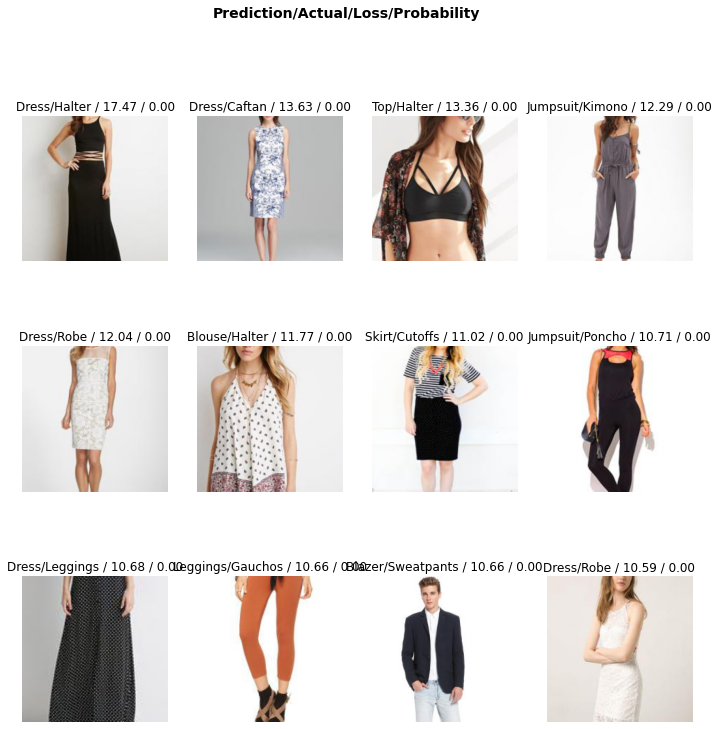

In [49]:
# evaluate model

# model summary
print(learner.model.module)
learner_eval = ClassificationInterpretation.from_learner(learner)
learner_eval.plot_top_losses(12)

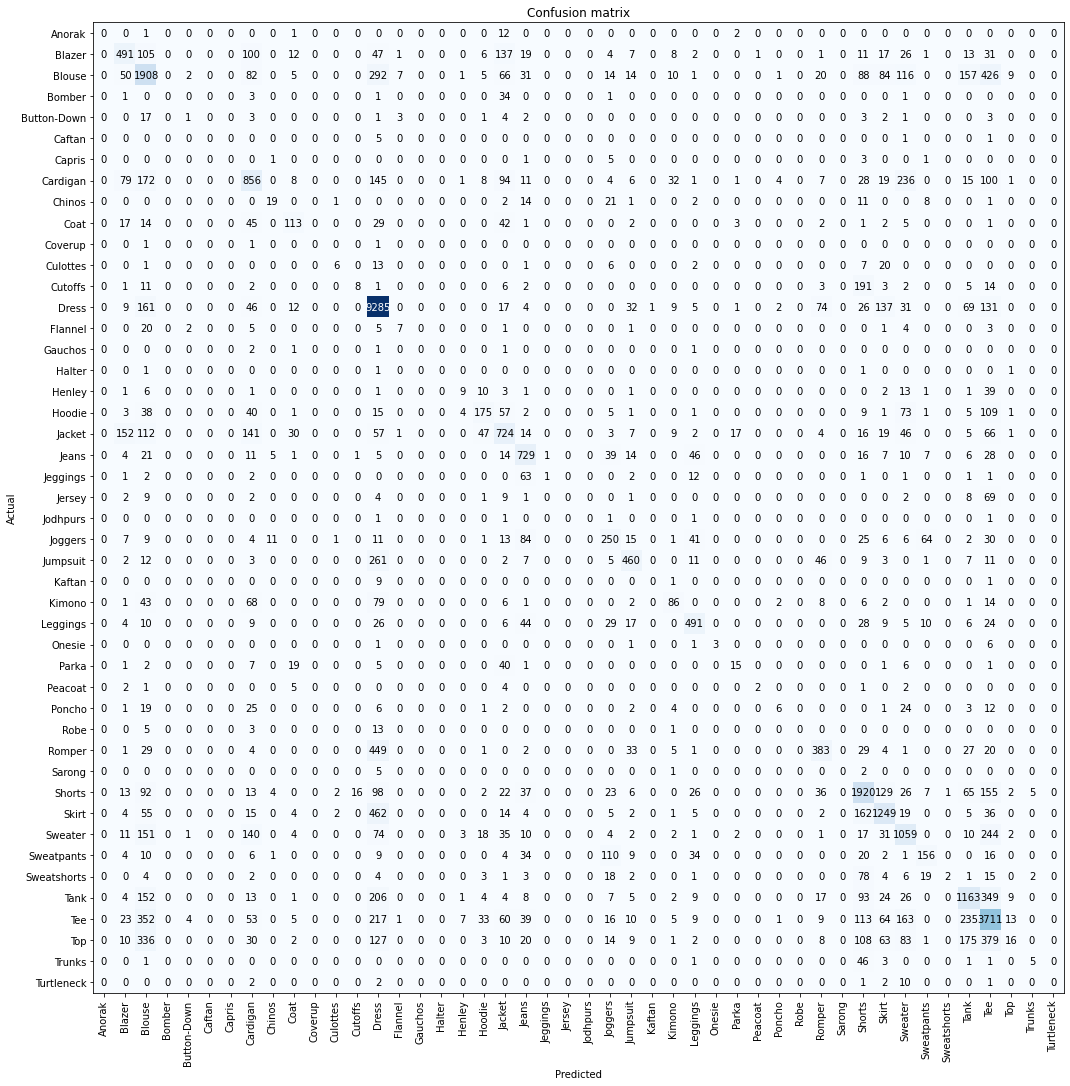

In [52]:
# confusion matrix
learner_eval.plot_confusion_matrix(figsize=(15, 15))

## **Load Module and Find Similar Embeddings**

In [ ]:
# load model after transfer learning
model_dir = '/content/drive/MyDrive/resnet18-DeepFashion'
pretrained_model = models.resnet18
metrics = [accuracy, partial(top_k_accuracy, k=1), partial(top_k_accuracy, k=5)]
learner = cnn_learner(data, pretrained_model, metrics=metrics) #create model instance
learner.model = torch.nn.DataParallel(learner.model) # utilize gpu
learner = learner.load(model_dir) # load model

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [ ]:
# creates a hook to save features from resnet model
class SaveFeatures():
  features = None
  def __init__(self, model_layer):
    self.hook = model_layer.register_forward_hook(self.hook_fn)
    self.features = None
  def hook_fn(self, module, input, output):
    out = output.detach().cpu().numpy()
    if isinstance(self.features, type(None)):
      self.features = out
    else:
      self.features = np.row_stack((self.features, out))
  def remove(self):
    self.hook.remove()


In [ ]:
# generate embeddings for training and validation images
saved_features = SaveFeatures(learner.model.module[1][4])
_= learner.get_preds(data.train_ds)
_= learner.get_preds(DatasetType.Valid)

In [ ]:
# save features
print(saved_features.features)
np.save('/content/drive/MyDrive/saved_features', np.array(saved_features.features))